Dogs = 1 , Cats = 0

In [ ]:
!wget https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip

--2025-05-11 12:59:07--  https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.2.74.10, 2600:1407:a800:497::317f, 2600:1407:a800:4b0::317f, ...
Connecting to download.microsoft.com (download.microsoft.com)|23.2.74.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip.2’

kagglecatsanddogs_5 100%[===================>] 786.67M  11.4MB/s    in 12s     

2025-05-11 12:59:20 (63.1 MB/s) - ‘kagglecatsanddogs_5340.zip.2’ saved [824887076/824887076]



In [58]:
!unzip kagglecatsanddogs_5340.zip

Archive:  kagglecatsanddogs_5340.zip
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace PetImages/Cat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Import library

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tqdm
import os
import random
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

## Create a Data frame for Input and Output

In [61]:
# Create a Data frame for Input and Output
input_path = []
label = []

for class_name in os.listdir("PetImages"):
  for path in os.listdir("PetImages/"+class_name): # Use os.path.join for platform-independent path construction
    if class_name == 'Cat':
      label.append(0)
    elif class_name == 'Dog':
      label.append(1)
    else:
      continue
    input_path.append(os.path.join("PetImages",class_name, path))
print(input_path[0], label[0])


PetImages/Cat/2258.jpg 0


In [62]:
df = pd.DataFrame()
df['Images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Images,label
0,PetImages/Dog/3475.jpg,1
1,PetImages/Cat/2754.jpg,0
2,PetImages/Cat/4817.jpg,0
3,PetImages/Cat/3260.jpg,0
4,PetImages/Dog/8872.jpg,1


#Delete db file

In [67]:
for i in df ['Images']:
  if '.jpg' not in i:
    print(i)

PetImages/Cat/Thumbs.db
PetImages/Dog/Thumbs.db


In [77]:
#delete db files

df = df[df['Images']!='PetImages/Dog/Thumbs.db']
df = df[df['Images']!='PetImages/Cat/Thumbs.db']
len(df)

25000

In [96]:
import PIL
l = []
for image in df['Images']:
  try:
    img = PIL.Image.open(image)
  except:
      l.append(image)
l

['PetImages/Cat/666.jpg', 'PetImages/Dog/11702.jpg']

In [97]:
df = df[df['Images'] != 'PetImages/Dog/Thumbs.db']
df = df[df['Images'] != 'PetImages/Cat/Thumbs.db']


#EDA

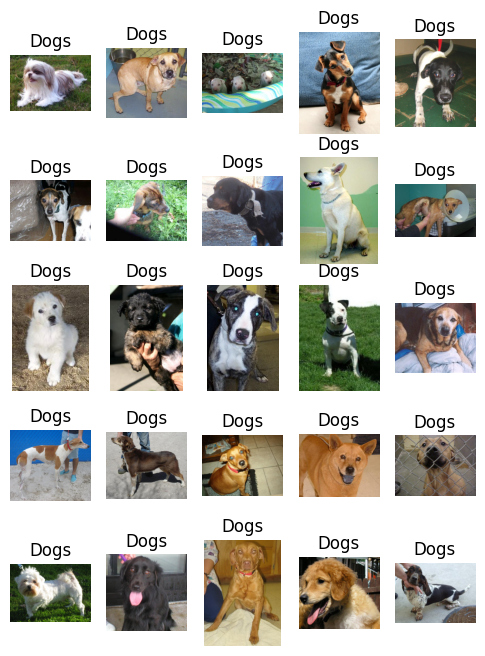

In [64]:
plt.figure(figsize=(6,8))
temp = df[df['label']==1]['Images'] # Changed 'images' to 'Images'
start = random.randint(0, len(temp)) # Corrected the typo 'randit' to 'randint'
files = temp[start:start+25]

for index, file in enumerate (files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Dogs')
  plt.axis('off')


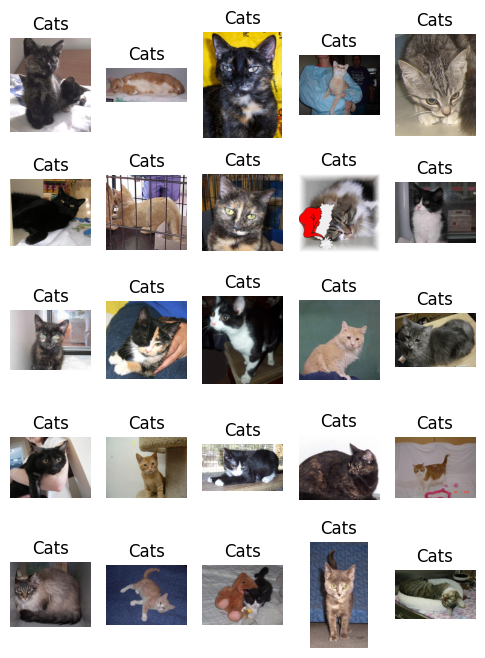

In [65]:
plt.figure(figsize=(6,8))
temp = df[df['label']==0]['Images'] # Changed 'images' to 'Images'
start = random.randint(0, len(temp)) # Corrected the typo 'randit' to 'randint'
files = temp[start:start+25]

for index, file in enumerate (files):
  plt.subplot(5,5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Cats')
  plt.axis('off')


# Apply viualization using seaborn

<Axes: ylabel='count'>

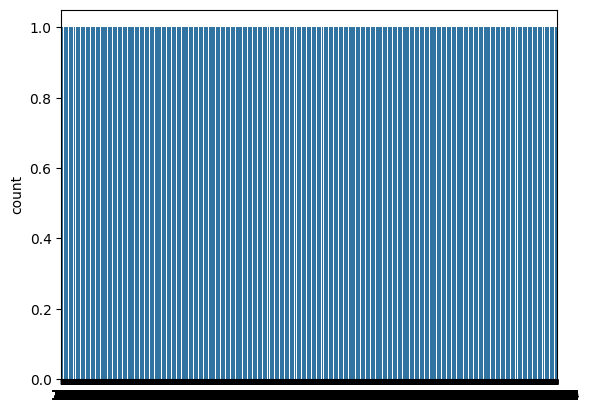

In [66]:
import seaborn as sns # import library
sns.countplot(df['label'])

In [ ]:
df['label'] = df['label'].astype('str')

In [ ]:
df.head()

,Images,label
0,PetImages/Cat/3185.jpg,0
1,PetImages/Cat/3720.jpg,0
2,PetImages/Cat/2852.jpg,0
3,PetImages/Dog/911.jpg,1
4,PetImages/Dog/10480.jpg,1


In [81]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [82]:
test.head()

,Images,label
6868,PetImages/Dog/7953.jpg,1
24018,PetImages/Dog/12137.jpg,1
9669,PetImages/Dog/769.jpg,1
13641,PetImages/Dog/3315.jpg,1
14019,PetImages/Cat/4469.jpg,0


In [100]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator
train_generator = ImageDataGenerator(
    rescale=1./255,  # Normalization of image
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator
val_generator = ImageDataGenerator(rescale=1./255)

train['label'] = train['label'].astype(str)
test['label'] = test['label'].astype(str)

# Train iterator
train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col='Images',
    y_col='label',
    target_size=(128, 128),
    batch_size=512,
    class_mode='binary'
)

# Validation iterator
val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col='Images',
    y_col='label',
    target_size=(128, 128),
    batch_size=512,
    class_mode='binary'
)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


#Model creation

In [101]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPool2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [102]:
model.compile(optimizer='adam', loss='binary_cross_entropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    14,746,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,751,713 (56.27 MB)

 Trainable params: 14,751,713 (56.27 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

#make model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Model compile

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model prediction

history = model.fit(train_iterator, epochs=50, validation_data=val_iterator)


Epoch 1/50
13/40 ━━━━━━━━━━━━━━━━━━━━ 4:39 10s/step - accuracy: 0.5195 - loss: 7.6760

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x79422314a5c0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 248, in _finite_generator
    yield self._standardize_batch(self.py_dataset[i])
                                  ~~~~~~~~~~~~~~~^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
          ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/image_utils.py", line 236, in load_img
    img = pil_image.open(io.BytesIO(f.read()))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/PIL/Image.py", line 3572, in open
    raise UnidentifiedImageError(msg)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x79422314a5c0>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_3662]

In [106]:
import cv2
import os

def check_image(file_path):
    try:
        img = cv2.imread(file_path)
        if img is None:
            print(f"Corrupted image: {file_path}")
    except Exception as e:
        print(f"Error loading image: {file_path}, Error: {str(e)}")

for img_path in train['Images']:
    check_image(img_path)
for img_path in test['Images']:
    check_image(img_path)


Corrupted image: PetImages/Dog/2688.jpg
Corrupted image: PetImages/Dog/7133.jpg
Corrupted image: PetImages/Dog/3136.jpg
Corrupted image: PetImages/Cat/140.jpg
Corrupted image: PetImages/Cat/10501.jpg
Corrupted image: PetImages/Dog/10158.jpg
Corrupted image: PetImages/Cat/5553.jpg
Corrupted image: PetImages/Cat/9778.jpg
Corrupted image: PetImages/Dog/11849.jpg
Corrupted image: PetImages/Cat/11935.jpg
Corrupted image: PetImages/Dog/1308.jpg
Corrupted image: PetImages/Dog/11853.jpg
Corrupted image: PetImages/Cat/10125.jpg
Corrupted image: PetImages/Cat/660.jpg
Corrupted image: PetImages/Dog/11410.jpg
Corrupted image: PetImages/Dog/6059.jpg
Corrupted image: PetImages/Cat/7978.jpg
Corrupted image: PetImages/Dog/7112.jpg
Corrupted image: PetImages/Cat/3300.jpg
Corrupted image: PetImages/Cat/3491.jpg
Corrupted image: PetImages/Cat/11565.jpg
Corrupted image: PetImages/Cat/11210.jpg
Corrupted image: PetImages/Cat/10820.jpg
Corrupted image: PetImages/Dog/11675.jpg
Corrupted image: PetImages/Dog/

In [107]:
from PIL import Image

for img_path in train['Images']:
    img = Image.open(img_path)
    if img.mode != 'RGB':
        print(f"Non-RGB image: {img_path} - Mode: {img.mode}")


Non-RGB image: PetImages/Dog/2688.jpg - Mode: P
Non-RGB image: PetImages/Dog/7133.jpg - Mode: P
Non-RGB image: PetImages/Dog/3136.jpg - Mode: P
Non-RGB image: PetImages/Cat/140.jpg - Mode: P
Non-RGB image: PetImages/Cat/10501.jpg - Mode: P
Non-RGB image: PetImages/Dog/10158.jpg - Mode: P
Non-RGB image: PetImages/Cat/5553.jpg - Mode: P
Non-RGB image: PetImages/Dog/1789.jpg - Mode: CMYK
Non-RGB image: PetImages/Cat/9778.jpg - Mode: P
Non-RGB image: PetImages/Dog/11849.jpg - Mode: P
Non-RGB image: PetImages/Cat/11935.jpg - Mode: P
Non-RGB image: PetImages/Dog/1308.jpg - Mode: P
Non-RGB image: PetImages/Dog/11853.jpg - Mode: P
Non-RGB image: PetImages/Cat/12080.jpg - Mode: P
Non-RGB image: PetImages/Cat/10125.jpg - Mode: P
Non-RGB image: PetImages/Cat/660.jpg - Mode: P
Non-RGB image: PetImages/Dog/1773.jpg - Mode: L
Non-RGB image: PetImages/Dog/11410.jpg - Mode: P
Non-RGB image: PetImages/Dog/6059.jpg - Mode: P
Non-RGB image: PetImages/Cat/7978.jpg - Mode: P
Non-RGB image: PetImages/Dog/71

UnidentifiedImageError: cannot identify image file 'PetImages/Dog/11702.jpg'

In [108]:
batch = next(iter(train_iterator))
print(f"Batch X shape: {batch[0].shape}, Batch Y shape: {batch[1].shape}")


Batch X shape: (512, 128, 128, 3), Batch Y shape: (512,)


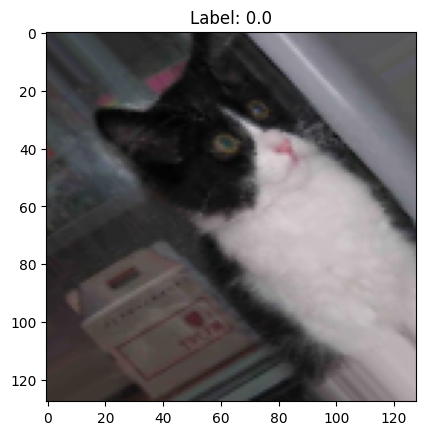

In [109]:
import matplotlib.pyplot as plt

for batch in train_iterator:
    img, label = batch
    plt.imshow(img[0])
    plt.title(f"Label: {label[0]}")
    plt.show()
    break
